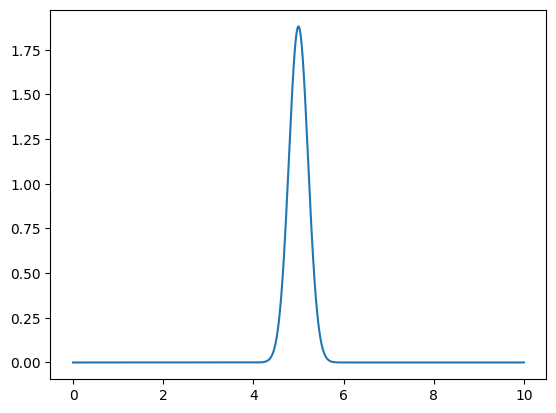

Step 0, Norm = 1.000000


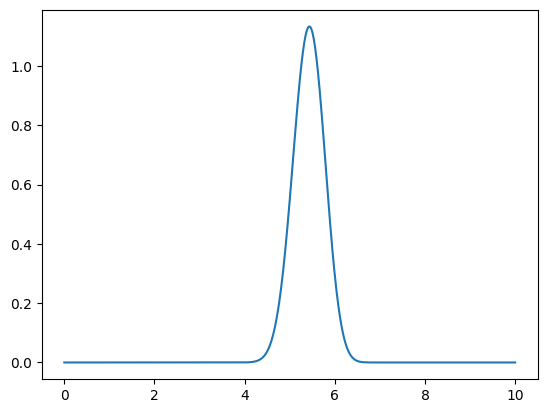

Step 100000, Norm = 1.000000


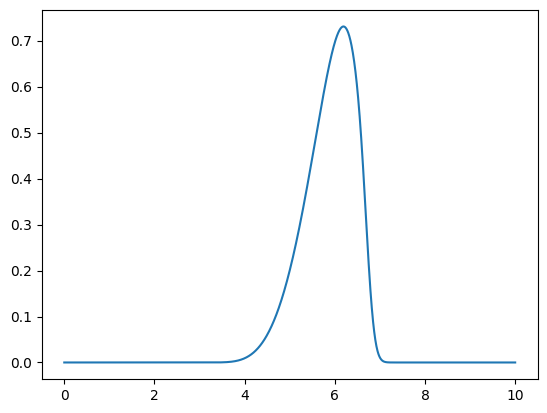

Step 200000, Norm = 1.000000


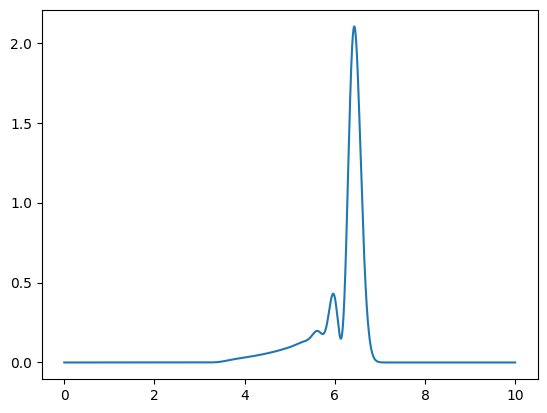

Step 300000, Norm = 1.000000


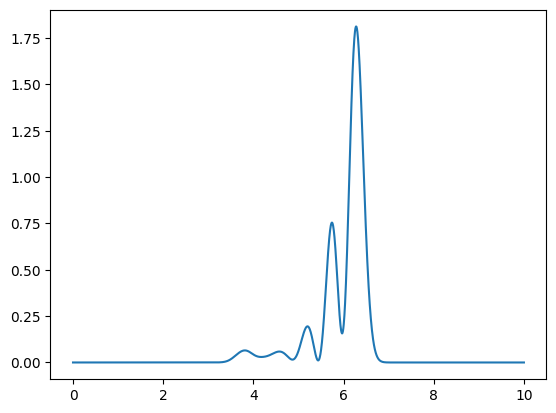

Step 400000, Norm = 1.000000


In [1]:
import numpy as np
from Hamiltonian import Hamiltonian
from time_evolution import Split_Operator
from Visualization import Visualize
import matplotlib.pyplot as plt

def quartic_double_well(x,a,b,V_max,L=None):
    V = (V_max / b**4 )*(((x-(a/2))**2)-b**2)**2
    #V_max value of potential at the center barrier
    # a,b control geometry of potential
    return V

def gaussian_wavepacket(x, x0, sigma, k0):
    psi0 = np.exp(-(x-x0)**2/(2*sigma**2)) * np.exp(1j*k0*x)
    psi0 = psi0 / np.sqrt(np.trapezoid(np.abs(psi0)**2, x))
    return psi0



N = 2048
L = 10.0  # Bohr
num_states = 8

V_max = 10.0
b = 1
a = L  

H = Hamiltonian(
    N=N,
    L=L,
    potential_func=lambda x, L: quartic_double_well(x, a=a, b=b, V_max=V_max),
    ndim=1,
    num_states=num_states,
    bc='dirichlet'
)
x = H.X


evals, evecs = H.solve()

# 4. Initial wave packet

x0 = 5.0
sigma = 0.3
k0 = 4.0

psi0 = gaussian_wavepacket(x,x0,sigma,k0)


# 5. Time evolution (split operator)
solver = Split_Operator(
    N=N,
    L=L,
    potential_func=quartic_double_well,
    mass=1.0,
    dt=1e-6,
    V_max=V_max, a=a, b=b
)

solver.absorbing_boundary(start_frac=0.85)

psi = psi0.copy()
steps = 500000


for n in range(steps):
    psi = solver.step(psi)
    

    if n % 100000 == 0:
        plt.plot(x, np.abs(psi)**2)
        plt.show()
        norm = np.trapezoid(np.abs(psi)**2, x)
        print(f"Step {n}, Norm = {norm:.6f}")


--- Generating plots for 1D_double_well ---


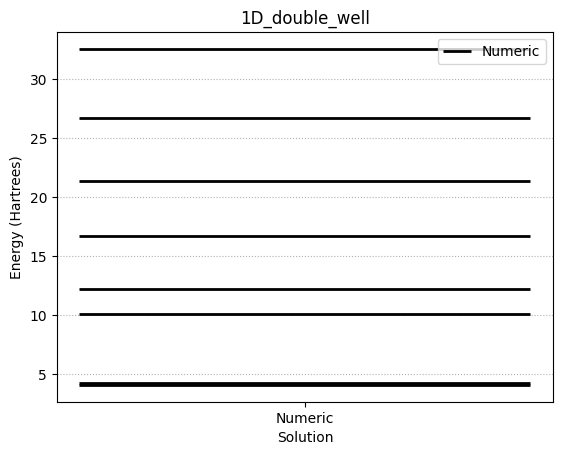

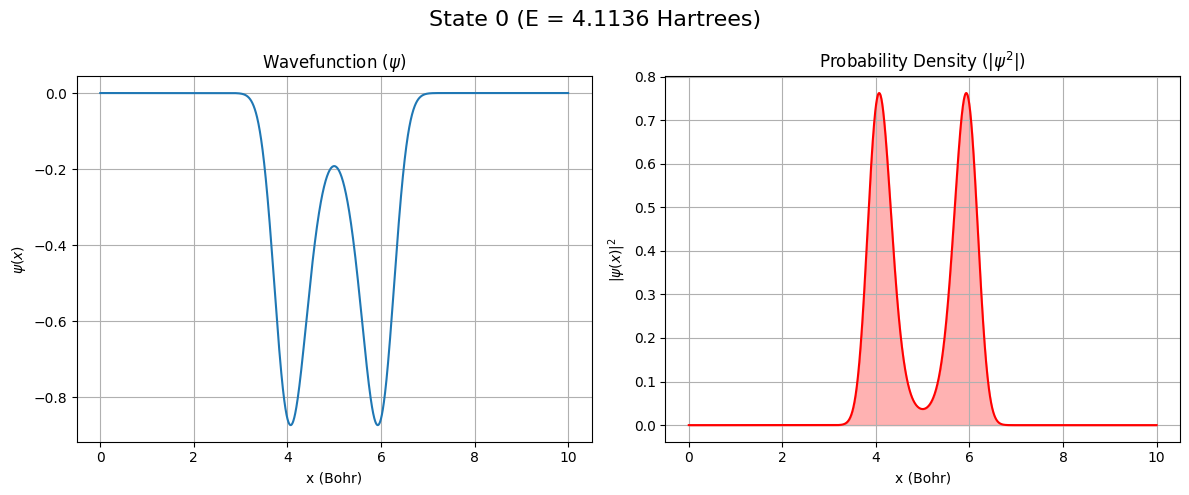

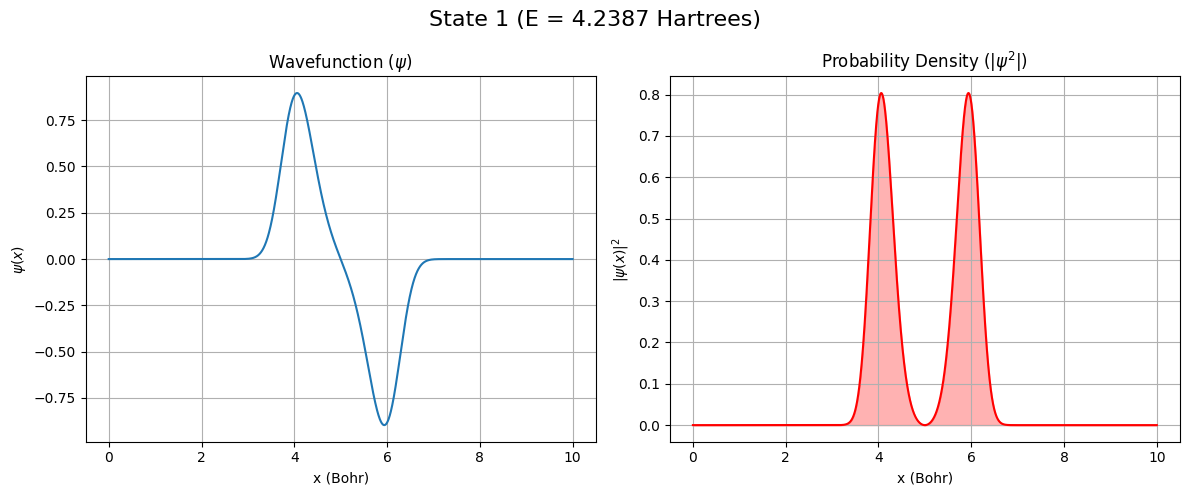

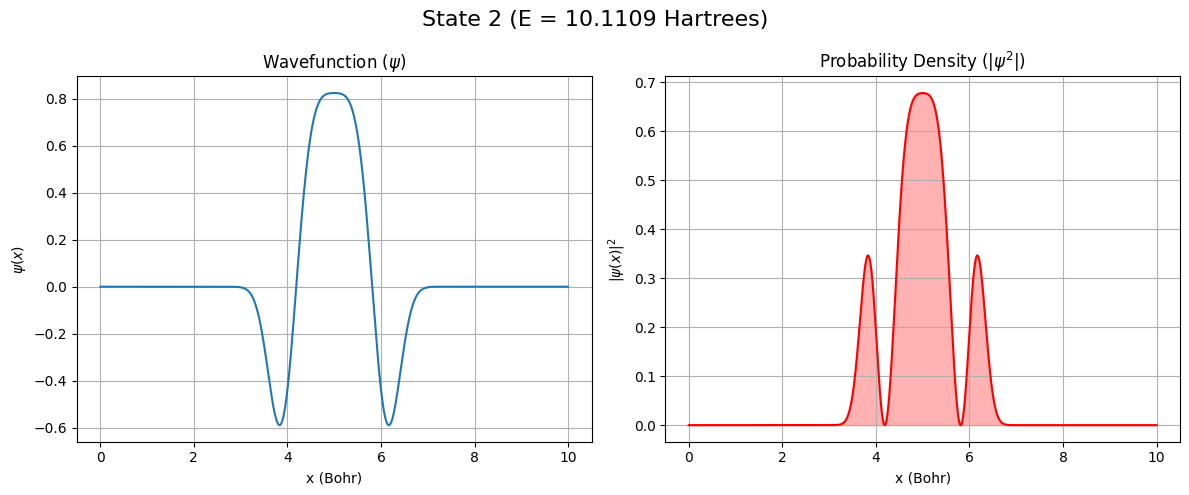

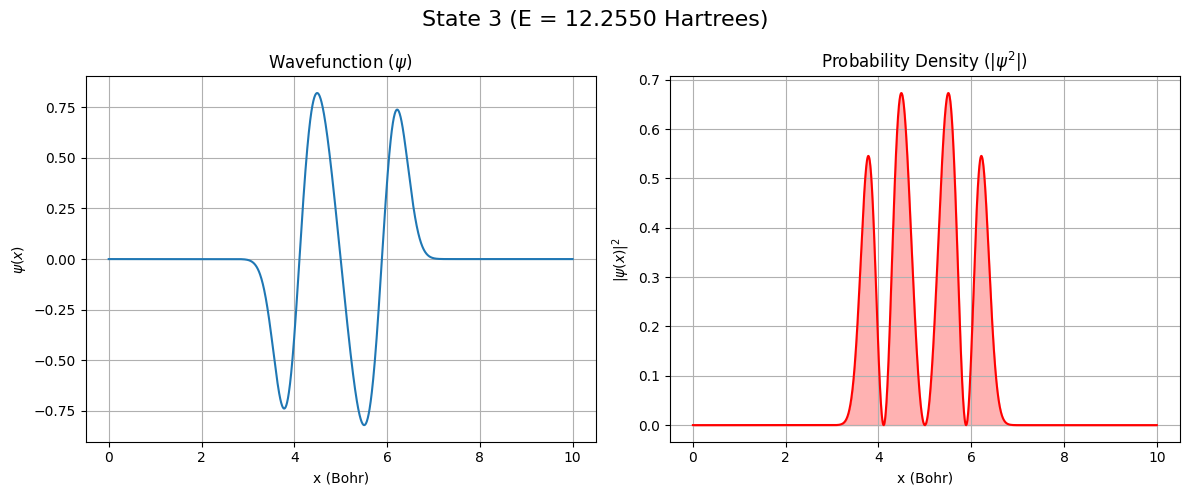

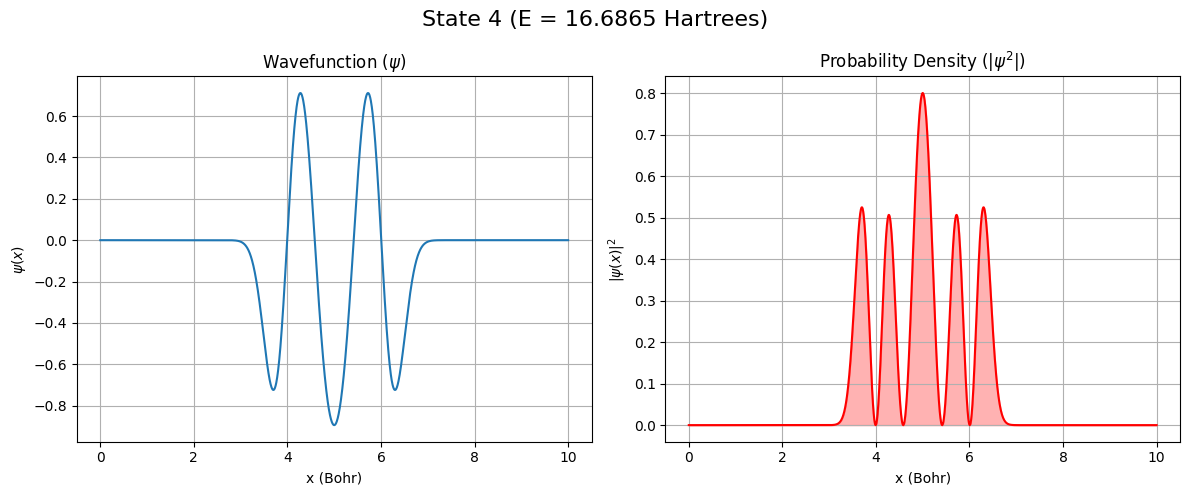

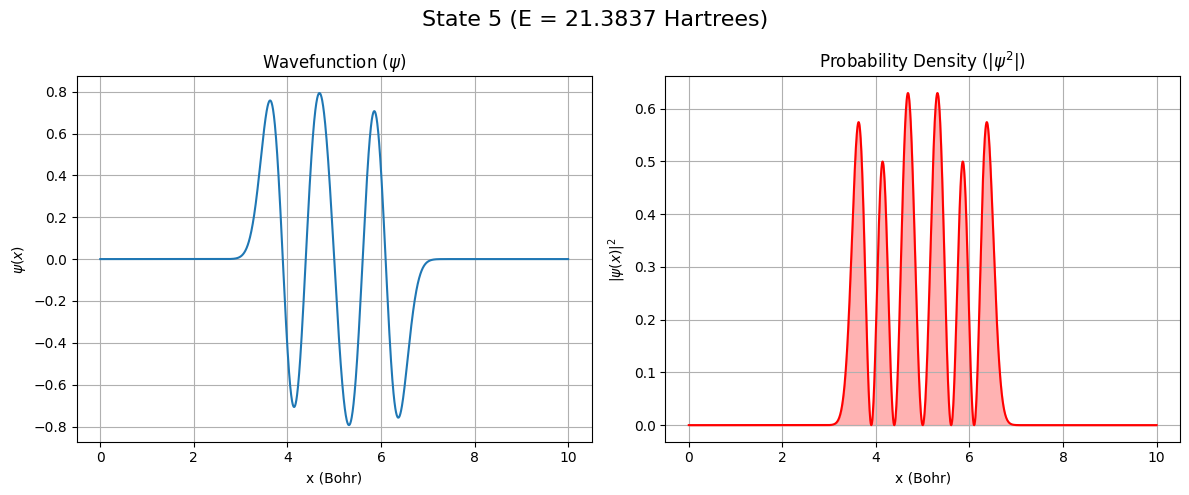

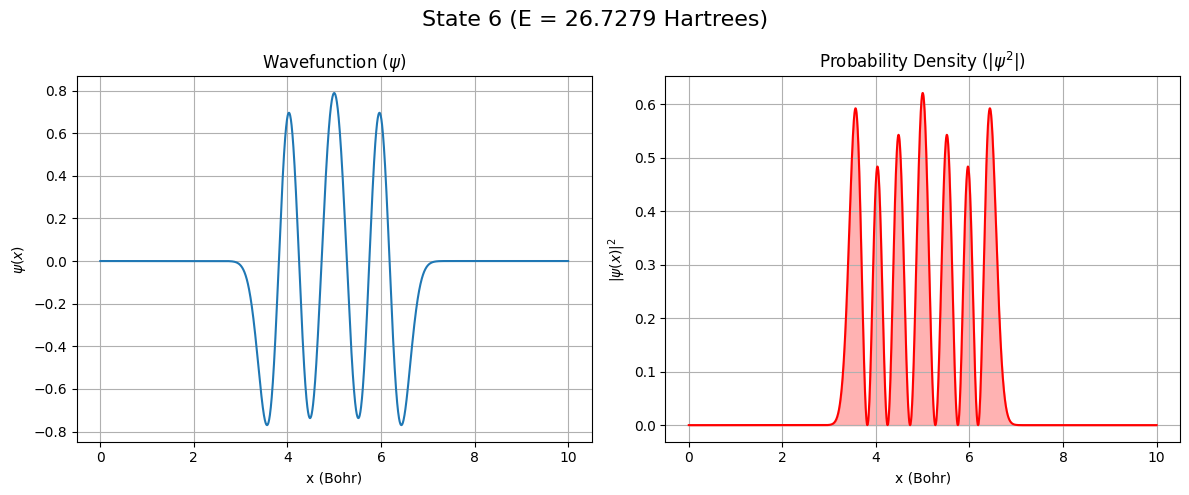

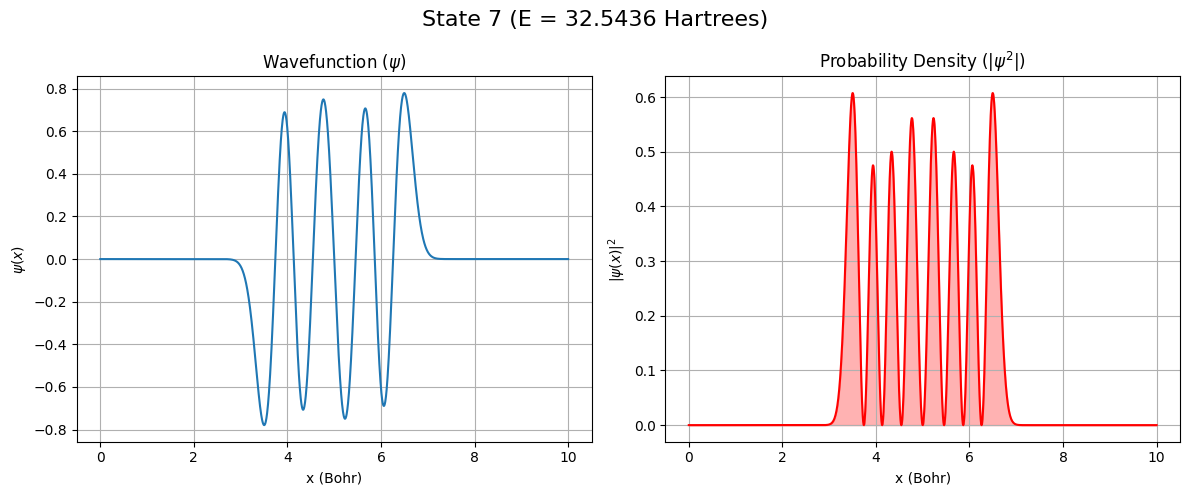

In [2]:
H.test_case_name = "1D_double_well"
vis = Visualize(H,states_to_plot=8)
vis.plot_all()

3.8146954448577224e-05 5760.0


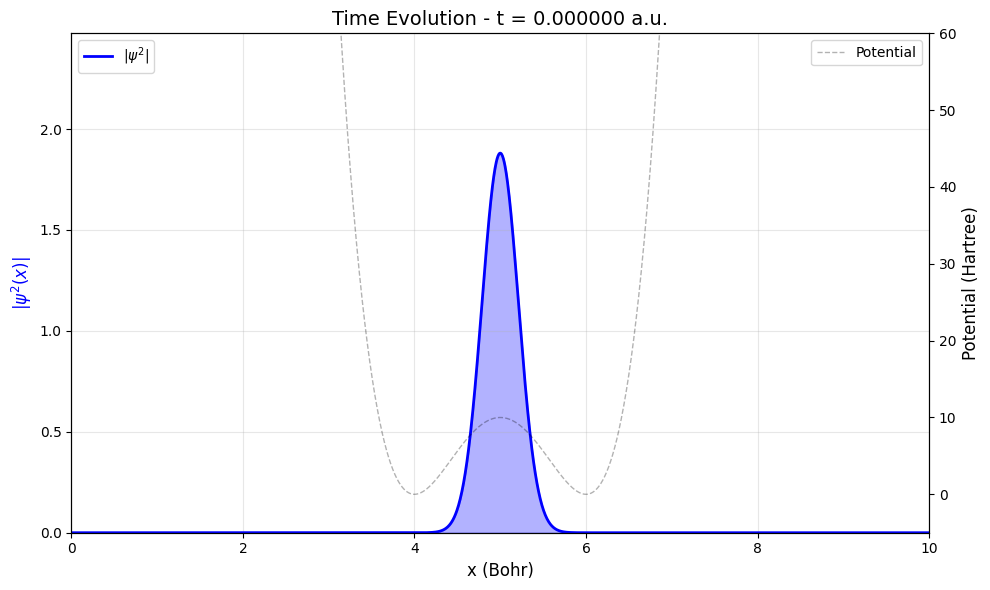

In [55]:
# Animate time evolution
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Reset wavefunction to initial state
psi = psi0.copy()

# Store snapshots for animation (every nth step to save memory)
snapshot_interval = 5000  # Store every ___ steps
snapshots = []
times = []
prob_densities = []

# Get potential for plotting
V = quartic_double_well(x, a=a, b=b, V_max=V_max)

# Run evolution and collect snapshots
for n in range(steps):
    psi = solver.step(psi)
    
    if n % snapshot_interval == 0:
        snapshots.append(psi.copy())
        times.append(n * solver.dt)
        prob_densities.append(np.abs(psi)**2)

# Convert to arrays
prob_densities = np.array(prob_densities)
times = np.array(times)

# Create animation
fig, ax = plt.subplots(figsize=(10, 6))

# Plot potential on right y-axis
ax_twin = ax.twinx()
ax_twin.plot(x, V, 'k--', alpha=0.3, linewidth=1, label='Potential')

# Initial probability density on left y-axis
line, = ax.plot(x, prob_densities[0], 'b-', linewidth=2, label=r'|$\psi^{2}$|')
fill = ax.fill_between(x, prob_densities[0], alpha=0.3, color='blue')

# Set up axes
ax.set_xlabel('x (Bohr)', fontsize=12)
ax.set_ylabel(r'|$\psi^{2}(x)$|', fontsize=12, color='b')
ax_twin.set_ylabel('Potential (Hartree)', fontsize=12, color='k')
ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, prob_densities.max() * 1.1)

# Make sure potential is fully visible on right axis
V_lower, V_upper = V.min(), V.max()
V_range = V_upper - V_lower
ax_twin.set_ylim(-5, 60) #V_lower - 0.1 * V_range, V_upper + 0.1 * V_range)
print(V_lower, V_upper)

# Title with time
title = ax.set_title(f'Time Evolution - t = {times[0]:.6f} a.u.', fontsize=14)
ax.legend(loc='upper left')
ax_twin.legend(loc='upper right')  # Add legend for potential on right side
ax.grid(True, alpha=0.3)

# Animation function
def animate(frame):
    line.set_ydata(prob_densities[frame])
    # Update fill_between by removing old and adding new
    if len(ax.collections) > 1:  # More than just the potential line
        ax.collections[-1].remove()  # Remove the last fill_between
    ax.fill_between(x, prob_densities[frame], alpha=0.3, color='blue')
    title.set_text(f'Time Evolution - t = {times[frame]:.6f} a.u.')
    return [line, title]

# Create animation
anim = FuncAnimation(
    fig, 
    animate, 
    frames=len(prob_densities), 
    interval=50,
    blit=False,
    repeat=True
)

plt.tight_layout()
plt.show()

In [56]:
# Save animation
anim.save('1d_time_evolution.mp4', fps=20, extra_args=['-vcodec', 'libx264'])